In [1]:
## Code for making Figure 6 (and app.)

In [2]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy as sp
from scipy import stats
import time
plt.style.use('tableau-colorblind10')

def eval_lats(pred, target, res=1000):
    errs = np.zeros((2, res))
    for i in range(2):
        for i_s, s in enumerate(np.linspace(0, 2 * np.pi, res)):
            newpred = 2 * (0.5 - i) * pred + s
            errs[i, i_s] = np.mean(np.arccos(np.cos(newpred - target)))
            
    i, s = np.unravel_index(errs.argmin(), errs.shape)
            
    return np.amin(errs), 2 * (0.5 - i), np.linspace(0, 2 * np.pi, res)[s]

In [3]:
def return_plot_elements(
    model_type, #{'VAE', 'mGP'}
    feature_type, #{'bump', 'shared', 'separate',  'orig'}
    vae_inference, #{'True', 'False'}
    rate_or_latents #{'latents', 'LLH'}
):  
    if model_type == 'mGP':
        file_name = os.path.join(os.getcwd(),'results', 'peyrache_results','peyrache_results.p')
        
        with open(file_name, 'rb') as handle:
            stats_ = pickle.load(handle)
        
        n_sims = len(stats_['pred_corrs'][1,:,0])
        
        if rate_or_latents == 'rates':
            corr_list = stats_['pred_corrs'][1,:,0]
            best = np.argmax(stats_['marg_liks'][1,:,0])
            
            return corr_list, best, 0, 0, 0
        
        if rate_or_latents == 'latents':
            err_list = stats_['lat_errs'][1,:,0]
            best = np.argmax(stats_['marg_liks'][1,:,0])
            
            return err_list, best, 0, 0, 0, 0
        
    else:       
        file_name = os.path.join(os.getcwd(), 'results', 'fig4_stats_peyrache_%s_%s_doinf_%s.pkl' % (
            model_type, feature_type, vae_inference))

        with open(file_name, 'rb') as handle:
            stats_ = pickle.load(handle)

        n_sims = len(stats_['corr_rates'])    

        if rate_or_latents == 'rates':
            corr_list = stats_['corr_rates']
            if np.any(np.isnan(stats_['corr_rates'])):
                corr_list[np.argwhere(np.isnan(corr_list))[0][0]] = 0
            best = np.argmin(stats_['llh_train_train'])

            neurons_test_ind = stats_['neurons_test_ind'][0]
            y_pred = stats_['y_pred'][best]
            y_test = stats_['y_test'][best]
            if model_type == 'GP':
                y_pred = y_pred[neurons_test_ind]
                y_test = y_test[neurons_test_ind]

            return corr_list, best, y_pred, y_test, neurons_test_ind
        
        elif rate_or_latents == 'LLH':
            temp = []
            for rep_num in range(n_sims):
                temp.append(np.sum(stats_['y_pred'][rep_num] - stats_['y_test'][rep_num] * np.log(stats_['y_pred'][rep_num] + 1e-9)))

            llh_list = temp
            best = np.argmin(stats_['llh_train_train'])
            
            neurons_test_ind = stats_['neurons_test_ind'][0]
            y_pred = stats_['y_pred'][best]
            y_test = stats_['y_test'][best]
            
            return llh_list, best, y_pred, y_test, neurons_test_ind

        elif rate_or_latents == 'latents':
            temp1 = []
            temp2 = []
            temp3 = []
            for i in range(n_sims):
                err, flip, shift = eval_lats(stats_['z_pred'][i], stats_['z_test'][i])
                temp1.append(err)
                temp2.append(flip)
                temp3.append(shift)

            err_list = temp1
            best = np.argmin(stats_['llh_train_train'])

            z_pred = stats_['z_pred'][best]
            z_test = stats_['z_test'][best]
            flip = temp2[best]
            shift = temp3[best]

            return err_list, best, z_pred, z_test, flip, shift
        

In [4]:
def make_plot():
  
    params1 = {
        'faeLVM-n' : ['VAE', 'separate_flex_64', 'True', 'LLH'],
        'faeLVM-s' : ['VAE', 'shared_flex_64', 'True', 'LLH'],
        'faeLVM-b' : ['VAE', 'bump_64', 'True', 'LLH']
        #'mGP' : ['mGP', 'orig', 'False', 'latents'],
    }

    params2 = {
        'faeLVM-n' : ['VAE', 'separate_flex_64', 'True', 'latents'],
        'faeLVM-s' : ['VAE', 'shared_flex_64', 'True', 'latents'],
        'faeLVM-b' : ['VAE', 'bump_64', 'True', 'latents'],
        'mGP' : ['mGP', 'orig', 'False', 'latents'],
        'VAE' : ['VAE', 'separate__mlp', 'False', 'latents'],
    }
    
    
    fig1, ax1 = plt.subplots(1,1, figsize=(4,4))
    fig2, (ax21, ax22, ax23) = plt.subplots(3,1, figsize=(4,4))
    fig3, ax3 = plt.subplots(1,1, figsize=(4,4))
    fig4, ax4 = plt.subplots(1,1, figsize=(4,4))
    fig5, ax5 = plt.subplots(1,1, figsize=(20,20))
    
    labels = []
    best_corrs = []
    for i, keyval in enumerate(params1.items()):
        corrs, best, y_pred, y_test, n_test_inds = return_plot_elements(*keyval[1])
        ax3.violinplot(corrs, positions=[i])
        if keyval[1][-1] == 'LLH':
            ax3.set_ylabel("Rate pred. [NLLH]", fontsize=20)
        else:
            ax3.set_ylabel("Rate pred. [corr.]", fontsize=20)
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        best_corrs.append(corrs[best])
        
        if keyval[0] == 'faeLVM-n':
            ax21.plot(y_test[0,:], color='black', alpha=0.2)
            ax21.plot(y_pred[0,:], color='black', label='Neur.  7')
            ax21.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax21.set_xticks([0, 1000])
            ax21.set_xticklabels([],  fontsize=15)
            ax22.plot(y_test[2,:],  color='black', alpha=0.2)
            ax22.plot(y_pred[2,:],  color='black', label='Neur. 15')
            ax22.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax22.set_xticks([0, 1000])
            ax22.set_xticklabels([], fontsize=15)
            ax23.plot(y_test[1,:],  color='black', alpha=0.2)
            ax23.plot(y_pred[1,:],  color='black', label='Neur. 20')
            ax23.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax23.set_xticks([0, 500, 1000])
            ax23.set_xticklabels([0, 'T', 1000], fontsize=15)
            ax23.get_xticklabels()[1].set_size(20)
            ax23.xaxis.get_major_ticks()[1].tick1line.set_markersize(0)
        
    ax3.set_aspect(1.0/ax3.get_data_ratio(), adjustable='box')
    inds = np.arange(0, len(params1.keys()))
    ax3.scatter(inds, best_corrs, marker='o', color='black', s=30, zorder=3)
    ax3.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
    ax3.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax3.tick_params(axis='y', labelsize=15)
    
    
    leg21 = ax21.legend(handlelength=0, handletextpad=0, fancybox=True, fontsize=15, loc='upper left')
    leg22 = ax22.legend(handlelength=0, handletextpad=0, fancybox=True, fontsize=15, loc='upper left')
    leg23 = ax23.legend(handlelength=0, handletextpad=0, fancybox=True, fontsize=15, loc='upper left')
    for item in leg21.legendHandles:
        item.set_visible(False)
    for item in leg22.legendHandles:
        item.set_visible(False)
    for item in leg23.legendHandles:
        item.set_visible(False)
    ax22.set_ylabel('[a.u.]', fontsize=20)


    best_errs = []
    for i, keyval in enumerate(params2.items()):
        errs, best, z_pred, z_test, flip, shift = return_plot_elements(*keyval[1])
        if keyval[0] == 'faeLVM-n':
            ax1.scatter(z_test, (flip * z_pred + shift) % (2 * np.pi), color='black', alpha=0.3)
            ax1.set_aspect(1.0/ax1.get_data_ratio(), adjustable='box')
            ax1.set_xticks([0,np.pi,2*np.pi])
            ax1.set_xticklabels([0, 'True head direction', r'$2\pi$'], fontsize=15)
            ax1.set_yticks([0,np.pi,2*np.pi])
            ax1.set_yticklabels([0, 'Inferred latent', r'$2\pi$'], fontsize=15)
            ax1.get_yticklabels()[1].set_rotation('vertical')
            ax1.get_yticklabels()[1].set_verticalalignment('center')
            ax1.get_yticklabels()[1].set_size(20)
            ax1.get_xticklabels()[1].set_size(20)
            ax1.yaxis.get_major_ticks()[1].tick1line.set_markersize(0)
            ax1.xaxis.get_major_ticks()[1].tick1line.set_markersize(0)
            ax1.set_xlim(0, 2*np.pi)
            ax1.set_ylim(0, 2*np.pi)
        ax4.violinplot(errs, positions=[i])
        ax4.set_ylabel("Latent pred. [GE]", fontsize=20)
        ax4.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        best_errs.append(errs[best])
        labels.append(keyval[0])
        #print(keyval[0])
        #print(errs)
    ax4.set_aspect(1.0/ax4.get_data_ratio(), adjustable='box')
    inds = np.arange(0, len(params2.keys()))
    ax4.scatter(inds, best_errs, marker='o', color='black', s=30, zorder=3)
    ax4.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax4.tick_params(axis='y', labelsize=15)
    
    
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    fig4.tight_layout()
    
    
    #fig1.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig4a_1" + ".pdf")
    #fig2.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig4a_2" + ".pdf")
    #fig3.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig4a_3" + ".pdf")
    #fig4.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig4a_4" + ".pdf")
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # alpha=0.3 diffuse parts of violin, alpah=1 solid part
    patches = [mpatches.Patch(color=colors[i], label=labels[i], alpha=1) for i in range(len(params2.keys()))]
    ax5.legend(handles=patches, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.5), edgecolor='black',
               fancybox=True, shadow=False, ncol=len(params2.keys()), fontsize=15)
    fig5.tight_layout()
    #fig5.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig4a_3_legend" + ".pdf")  
    

In [6]:
## Figure for app
def plot_latent():
    params = {
            'faeLVM-n' : ['VAE', 'separate_flex_64', 'True', 'latents']
        }
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig2, ax2 = plt.subplots(1,1, figsize=(12,4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    labels = ["True HD", "Inferred latent"]
    best_errs = []
    for i, keyval in enumerate(params.items()):
        errs, best, z_pred, z_test, flip, shift = return_plot_elements(*keyval[1])
        if keyval[0] == 'faeLVM-n':
            ax.scatter(z_test, (flip * z_pred + shift) % (2 * np.pi), color='black', alpha=0.3)
            ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
            #ax.set_xticks([0,np.pi,2*np.pi], labels=[0, 'True head direction', r'$2\pi$'], fontsize=15)
            ax.set_xticks([0,np.pi,2*np.pi])
            ax.set_xticklabels([0, 'True head direction', r'$2\pi$'], fontsize=15)
            #ax.set_yticks([0,np.pi,2*np.pi], [0, 'Inferred latent', r'$2\pi$'], fontsize=15)
            ax.set_yticks([0,np.pi,2*np.pi])
            ax.set_yticklabels([0, 'Inferred latent', r'$2\pi$'], fontsize=15)
            ax.get_yticklabels()[1].set_rotation('vertical')
            ax.get_yticklabels()[1].set_verticalalignment('center')
            ax.get_yticklabels()[1].set_size(20)
            ax.get_xticklabels()[1].set_size(20)
            ax.yaxis.get_major_ticks()[1].tick1line.set_markersize(0)
            ax.xaxis.get_major_ticks()[1].tick1line.set_markersize(0)
            ax.set_xlim(0, 2*np.pi)
            ax.set_ylim(0, 2*np.pi)
            
            ax2.plot(z_test, color=colors[0], ls='-', label="True HD")
            ax2.plot((flip * z_pred + shift) % (2 * np.pi), color=colors[1], label="Inferred latent")
            ax2.set_yticks([0,np.pi,2*np.pi])
            ax2.set_yticklabels([0, r'Angle $(\theta)$', r'$2\pi$'], fontsize=15)
            ax2.get_yticklabels()[1].set_rotation('vertical')
            ax2.get_yticklabels()[1].set_verticalalignment('center')
            ax2.get_yticklabels()[1].set_size(20)
            ax2.get_xticklabels()[1].set_size(20)
            ax2.yaxis.get_major_ticks()[1].tick1line.set_markersize(0)
            ax2.set_xticks([0, 200, 400, 500, 600, 800, 1000])
            ax2.set_xticklabels([0, 200, 400, 'T', 600, 800, 1000], fontsize=15)
            ax2.get_xticklabels()[3].set_size(20)
            ax2.xaxis.get_major_ticks()[3].tick1line.set_markersize(0)

        #print(keyval[0])
        #print(errs)
    fig.tight_layout()
    patches = [mpatches.Patch(color=colors[i], label=labels[i], alpha=1) for i in range(2)]
    fig2.legend(handles = patches, fontsize=15, loc='lower right', bbox_to_anchor=(0.49, 0.16, 0.5, 0.5))
    fig2.tight_layout()
    
    #fig.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig_app_3_1" + ".pdf")
    #fig2.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig_app_3_2" + ".pdf")
    

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kdais\\prog\\4222_understanding_neural_coding_on-Supplementary Material\\ICLR\\results\\fig4_stats_peyrache_VAE_separate_flex_64_doinf_True.pkl'

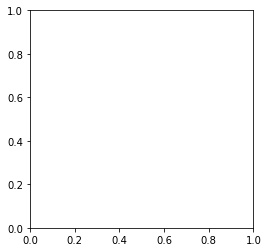

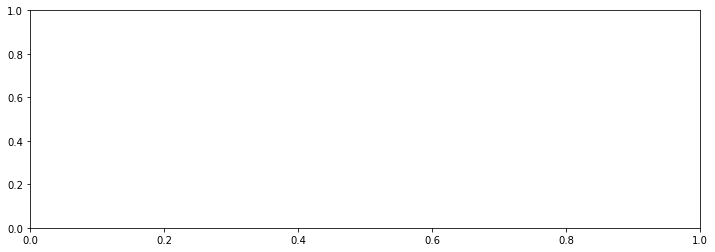

In [7]:
plot_latent()

In [ ]:
make_plot()